In [17]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from torch import nn,optim
import torch

import algo
import attack
import scripts

import os
import matplotlib.pyplot as plt
import json

rand_seed=24
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [48]:
# purchase
# load data with different seeds
data_seed = {}
for rand_seed in [1,3,13,24,42]:
    data_seed[rand_seed] =  {}
    
    data_seed[rand_seed]['x_target_train'] = np.load('data/rs'+str(rand_seed)+'_x_target_train.npy')
    data_seed[rand_seed]['y_target_train'] = np.load('data/rs'+str(rand_seed)+'_y_target_train.npy')
    data_seed[rand_seed]['x_target_test'] = np.load('data/rs'+str(rand_seed)+'_x_target_test.npy')
    data_seed[rand_seed]['y_target_test'] = np.load('data/rs'+str(rand_seed)+'_y_target_test.npy')
    data_seed[rand_seed]['n_classes'] = len(np.unique(y_target_train))
    data_seed[rand_seed]['X_train_size'] = x_target_train.shape[0]
    data_seed[rand_seed]['X_test_size ']= x_target_test.shape[0]

def set_the_seed_and_data(seed):
    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    random.seed(rand_seed)
    
    return data_seed[seed]['x_target_train'], data_seed[rand_seed]['y_target_train'], data_seed[rand_seed]['x_target_test'], data_seed[rand_seed]['y_target_test']

In [15]:
# attack models
from torch import nn

class Net_attack(nn.Module):

    def __init__(self, h_neurons, do, input_size):
        super(Net_attack, self).__init__()
        self.input_size = input_size
        self.h_neurons = h_neurons
        self.do = do
        self.fc1 = nn.Linear(input_size, h_neurons)
        self.fc2 = nn.Linear(h_neurons, 2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(do)
        self.softmax = nn.Softmax(dim=1)   

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.softmax(x)
        return x

path = 'mia'
ams = {}
for r,d,f in os.walk(path):
    for file in f:
        if "best_mi_model" in file:
            ams[file] = Net_attack(h_neurons=64, do=0, input_size=200)
            ams[file] = torch.load(r+'/'+file)      

In [37]:
# MI on target models

In [59]:
path = 'tm'
tms_params = {}
tms = {}
for r,d,f in os.walk(path):
    for file in f:
        if "target_model_params.json" in file:
            with open(path+'/'+file) as json_file:
                tms_params[file.replace('_params.json', '')] = json.load(json_file)
        if "target_model.npy" in file:
            tms[file.replace('.npy', '')] = np.load(path+'/'+file)
            
df = pd.DataFrame.from_dict(tms_params, orient='index')
df.shape            

(683, 21)

In [62]:
# attack every centralized target model
for file in tms_params:
    
    if 'attack_acc_mean' in tms_params[file]:
        continue
    # set random seed and load the data    
    rand_seed=int(file[file.find('rs')+2:file.find('_lr')])
    x_target_train, y_target_train, x_target_test, y_target_test = set_the_seed_and_data(rand_seed)
    
    #attack
    target_model = algo.LogisticRegression_DPSGD()
    target_model.theta = tms[file]
    params = tms_params[file]
    scripts.set_model_params(target_model, params)
    attack_dict = attack.test_mi_attack(ams, target_model, x_target_train, y_target_train, x_target_test, y_target_test)
    
    params.update(attack_dict)
    if 'attack_acc' in params:
        params.pop('attack_acc')
        params.pop('attack_pre')
        params.pop('attack_rec')
    #write a new parameters file with attack results
    with open('tm/'+file+'_params.json', 'w') as file:
        json.dump(params, file)
        

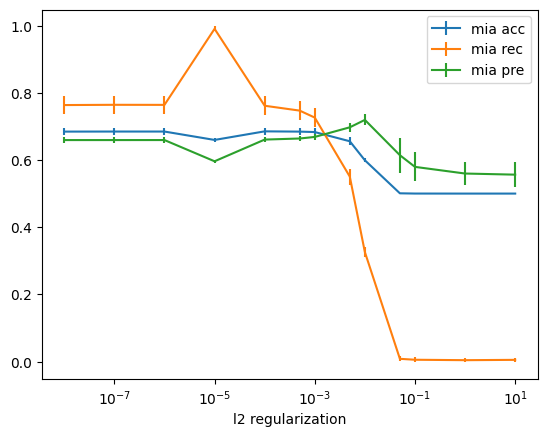

In [313]:
plt.errorbar(x, d_acc['mean'], d_acc['std'], label="mia acc")
plt.errorbar(x, d_rec['mean'], d_rec['std'], label="mia rec")
plt.errorbar(x, d_pre['mean'], d_pre['std'], label="mia pre")

plt.xscale("log")
plt.xlabel('l2 regularization')
plt.legend()
# plt.savefig(f'figures/mia/noDP_{show}{show1}rec.png')


In [309]:
splits = {}
for key in a_params:
    temp = key[key.find('_lr'):]
    if temp in splits:

        splits[temp]['attack_acc'].append(a_params[key]['attack_acc'])
        splits[temp]['attack_pre'].append(a_params[key]['attack_pre'])
        splits[temp]['attack_rec'].append(a_params[key]['attack_rec'])
    else:

        splits[temp] = {}
        splits[temp]['attack_acc'] = [a_params[key]['attack_acc']]
        splits[temp]['attack_pre'] = [a_params[key]['attack_pre']]
        splits[temp]['attack_rec'] = [a_params[key]['attack_rec']]

mean_res = {}
for key in splits:
    mean_res[key] = {}
    for metric in splits[key]:   
        mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))


rs13_lr0.001_iter100_reg0.005_DPFalse_target_model
rs42_lr0.001_iter100_reg0.005_DPFalse_target_model
rs1_lr0.001_iter100_reg0.01_DPFalse_target_model
rs1_lr0.001_iter100_reg10_DPFalse_target_model
rs42_lr0.001_iter100_reg0.0001_DPFalse_target_model
rs1_lr0.001_iter100_reg1e-07_DPFalse_target_model
rs42_lr0.001_iter100_reg0.0005_DPFalse_target_model
rs1_lr0.001_iter100_reg0.05_DPFalse_target_model
rs42_lr0.001_iter100_reg0.001_DPFalse_target_model
rs13_lr0.001_iter100_reg0.1_DPFalse_target_model
rs13_lr0.001_iter100_reg0.001_DPFalse_target_model
rs24_lr0.001_iter100_reg1e-05_DPFalse_target_model
rs42_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs13_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs42_lr0.001_iter100_reg0.01_DPFalse_target_model
rs1_lr0.001_iter100_reg1_DPFalse_target_model
rs42_lr0.001_iter100_reg0.05_DPFalse_target_model
rs1_lr0.001_iter100_reg0.005_DPFalse_target_model
rs1_lr0.001_iter100_reg1e-08_DPFalse_target_model
rs1_lr0.001_iter100_reg0.001_DPFalse_target_model

In [303]:
d_pre

,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-05_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-09_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg0_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-06_aepoch200,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg0.0001_aepoch500,best_mi_models_attack_model_aneur64_ado0_alr0.001_alreg1e-06_aepoch500,mean,std
0,0.659573,0.657639,0.656861,0.645084,0.671021,0.666235,0.659402,0.008127
1,0.659445,0.656860,0.657513,0.645084,0.670835,0.666663,0.659400,0.008149
2,0.660131,0.657971,0.657334,0.644999,0.670401,0.665768,0.659434,0.007914
3,0.595818,0.598490,0.589809,0.595790,0.591570,0.606012,0.596248,0.005230
4,0.661516,0.658761,0.657576,0.646822,0.672916,0.667498,0.660848,0.008186
5,0.664694,0.662488,0.661637,0.648693,0.676018,0.670814,0.664057,0.008500
6,0.670132,0.667324,0.665680,0.651784,0.681361,0.676136,0.668736,0.009263
7,0.703261,0.697172,0.699539,0.669924,0.708911,0.705329,0.697356,0.012841
8,0.728301,0.724283,0.725827,0.683096,0.726237,0.728934,0.719446,0.016330
9,0.653391,0.643574,0.648473,0.510764,0.584028,0.645805,0.614339,0.051932


In [ ]:
DPfalse_res_acc = {}
DPfalse_res_rec = {}
DPfalse_res_pre = {}

for n_am, best_am in enumerate(best_ams):
    a_model = Net_attack(h_neurons=64, do=0, input_size=100)
    a_model = ams[best_am]
    a_model.input_size = 200  
    
    a_params = dict(tms_params)

    for key in tms:
        if 'DPFalse' not in key:
            continue
        print(key)
        rand_seed = int(key[key.find('rs')+2:key.find('_lr')])
        x_target_train, y_target_train, x_target_test, y_target_test = data_shuffle(rand_seed, X_raw, y_raw)
        model = algo.LogisticRegression_DPSGD()
        model.n_classes = n_classes
        model.theta = tms[key]
        model.train_acc = model.evaluate(x_target_train, y_target_train, acc=True)
        model.test_acc = model.evaluate(x_target_test, y_target_test, acc=True)

        attack_acc, attack_pre, attack_rec = mi_attack_test(model, a_model, x_target_train, y_target_train, x_target_test, y_target_test)
        a_params[key]['attack_acc'] = attack_acc
        a_params[key]['attack_pre'] = attack_pre
        a_params[key]['attack_rec'] = attack_rec
        print(a_params[key])

    splits = {}
    for key in a_params:
    #     if 'rs13' not in key:
    # #     if 'rs13' not in key and 'rs42' not in key and 'rs24' not in key:
    #         continue
        temp = key[key.find('_lr'):]
        if temp in splits:

            splits[temp]['attack_acc'].append(a_params[key]['attack_acc'])
            splits[temp]['attack_pre'].append(a_params[key]['attack_pre'])
            splits[temp]['attack_rec'].append(a_params[key]['attack_rec'])
        else:

            splits[temp] = {}
            splits[temp]['attack_acc'] = [a_params[key]['attack_acc']]
            splits[temp]['attack_pre'] = [a_params[key]['attack_pre']]
            splits[temp]['attack_rec'] = [a_params[key]['attack_rec']]

    mean_res = {}
    for key in splits:
        mean_res[key] = {}
        for metric in splits[key]:   
            mean_res[key] [metric] = (np.mean(splits[key][metric]), np.std(splits[key][metric]))

    lr = 'lr0.001'
    it = 'iter100' 
    reg = 'reg1e-05'
    DP = 'DPFalse'
    show = f'{lr}_{it}' #f'{lr}_{it}_{reg}_{DP}'
    show1 = f'_{DP}'
    l2_res = {}
    l2_res_rec = {}
    l2_res_pre = {}
    for key in mean_res:
        if show in key and show1 in key:
            l2 = float(key[key.find('_reg')+4:key.find('_DPFalse')])
            l2_res[l2] = mean_res[key]['attack_acc']
            l2_res_rec[l2] = mean_res[key]['attack_rec']
            l2_res_pre[l2] = mean_res[key]['attack_pre']

    x = list(l2_res.keys())
    x.sort()
    DPfalse_res_acc[best_am] = [l2_res[i][0] for i in x]
    DPfalse_res_rec[best_am] = [l2_res_rec[i][0] for i in x]
    DPfalse_res_pre[best_am] = [l2_res_pre[i][0] for i in x]
